## Импорты

In [10]:
# импортируем необходимые библиотеки, классы и функции
import os
from datetime import datetime
import winsound
from etna.core import load
from etna.analysis import plot_backtest, plot_forecast
import torch
import random
from functools import partial
from pathlib import Path
import numpy as np

import optuna
from typing import Optional
import typer
from etna.loggers import WandbLogger
from etna.loggers import tslogger

import pandas as pd
from etna.datasets import TSDataset
from etna.datasets import generate_ar_df
from etna.metrics import (MAE, MSE, SMAPE, Sign)
from etna.models.nn import (RNNModel)
from etna.models.nn.utils import PytorchForecastingDatasetBuilder
from pytorch_forecasting.data import GroupNormalizer
from etna.pipeline import Pipeline, AutoRegressivePipeline
from etna.transforms import (LagTransform, 
                             LogTransform,
                             MeanTransform,
                             LinearTrendTransform,
                             TrendTransform)
from etna.transforms import (SegmentEncoderTransform,
                             StandardScalerTransform, 
                             MinMaxScalerTransform,
                             RobustScalerTransform,
                             TimeSeriesImputerTransform,
                             DateFlagsTransform)

from etna.transforms.decomposition import RupturesChangePointsModel
from ruptures.detection import Binseg
from etna.datasets import generate_ar_df
import warnings
warnings.filterwarnings('ignore')

## Код для проверки работы GPU

In [11]:
import torch
print(torch.cuda.is_available())
torch.set_float32_matmul_precision('medium')

True


## Пути к файлам модели и данных на диске и общие переменные

In [12]:
TRAIN_DATASET_PATH = "C:\\Users\\andre\\OneDrive\\Рабочий стол\\traindataset.csv"
MODEL_SAVING_PATH = "C:\\Users\\andre\\OneDrive\\Рабочий стол\\ВКР\\Модели\\neural_network.zip"
USING_MEASURE_POINTS =  166560 # 17532
HORIZON = 72
VALIDATION_MEASURE_POINTS_END = 171400+72 # 175320

## Функция загрузки данных и преобразования в формат ETNA

In [13]:
def get_etna_dataframe(sw_path, using_measure_points, target_list, regressors_list, with_solar_cycle_order_day_feature):
  # Получаем очищенные данные
  df = pd.read_csv(sw_path)
  df = df.head(using_measure_points)
  # преобразовываем столбец timestamp в столбец с временными метками
  df['timestamp'] = pd.to_datetime(df['timestamp'])

  # создаем дополнительную фичу в виде порядкового дня солнечного цикла
  if with_solar_cycle_order_day_feature:
      df = create_solar_cycle_order_day_feature(df=df, solar_cycles=solar_cycles)
      regressors_list.append('solar_cycle_day')
  
  df_target = df[target_list]
  df_regressors = df[regressors_list]
  # Подготавливаем регрессоры
  if regressors_list:
    df_regressors.columns = ["timestamp"] + [f"regressor_{i}_{regressors_list[i + 1]}" for i in range(len(regressors_list) - 1)]
    df_regressors["segment"] = "segment_0"
    df_regressors = TSDataset.to_dataset(df_regressors)
  # подготавливаем dataframe с целевой переменной
  df_target['target'] = df_target['v_plasma']
  df_target.drop(columns=['v_plasma'], inplace=True)
  df_target['segment'] = 'segment_0'
  # превращаем датафрейм
  # с плоским индексом в датафрейм с мультииндексом
  df_target = TSDataset.to_dataset(df_target)
  # превращаем датафрейм в объект TSDataset
  if not regressors_list:
    ts_target = TSDataset(df_target, freq='h')
  else:
    ts_target = TSDataset(df_target, freq='h', df_exog=df_regressors)
  # выполняем импутацию пропусков
  imputer = TimeSeriesImputerTransform(in_column='target',
                                      strategy='running_mean')
  ts_target.fit_transform([imputer])

  if regressors_list:
    for i in range(len(regressors_list)-1):
      imputer = TimeSeriesImputerTransform(in_column=f"regressor_{i}",
                                      strategy='running_mean')
      ts_target.fit_transform([imputer])

  return ts_target

## Функция добавления порядкового дня солнечного цикла в качестве экзогенной переменной

In [14]:
# Данные солнечных циклов
solar_cycles = [
    {"cycle": 1, "start": "1755-02"},
    {"cycle": 2, "start": "1766-06"},
    {"cycle": 3, "start": "1775-06"},
    {"cycle": 4, "start": "1784-09"},
    {"cycle": 5, "start": "1798-04"},
    {"cycle": 6, "start": "1810-07"},
    {"cycle": 7, "start": "1823-05"},
    {"cycle": 8, "start": "1833-11"},
    {"cycle": 9, "start": "1843-07"},
    {"cycle": 10, "start": "1855-12"},
    {"cycle": 11, "start": "1867-03"},
    {"cycle": 12, "start": "1878-12"},
    {"cycle": 13, "start": "1890-03"},
    {"cycle": 14, "start": "1902-01"},
    {"cycle": 15, "start": "1913-07"},
    {"cycle": 16, "start": "1923-08"},
    {"cycle": 17, "start": "1933-09"},
    {"cycle": 18, "start": "1944-02"},
    {"cycle": 19, "start": "1954-04"},
    {"cycle": 20, "start": "1964-10"},
    {"cycle": 21, "start": "1976-03"},
    {"cycle": 22, "start": "1986-09"},
    {"cycle": 23, "start": "1996-08"},
    {"cycle": 24, "start": "2008-12"},
    {"cycle": 25, "start": "2019-12"}
]

In [15]:
def create_solar_cycle_order_day_feature(df: pd.DataFrame, solar_cycles):
    # Преобразование строковых дат в datetime
    for cycle in solar_cycles:
        cycle['start'] = datetime.strptime(cycle['start'], '%Y-%m')
    
    # Функция для определения солнечного цикла и порядкового номера дня
    def get_solar_cycle_day(timestamp):
        for i in range(len(solar_cycles)-1, -1, -1):
            if timestamp >= solar_cycles[i]['start']:
                cycle_day = (timestamp - solar_cycles[i]['start']).days + 1
                return cycle_day
        return None
    
    # Применение функции к DataFrame
    df['solar_cycle_day'] = df['timestamp'].apply(get_solar_cycle_day)
    return df

## Функция отображения статистик по TSData и Pipeline

In [16]:
def print_TSDataset_statistic(df: TSDataset):
    print(f"*** Статистика по набору данных: ***\n {df.describe()} ]\n\n")
    print("Минимальные значения:")
    print(df.df.min())
    print("\nМаксимальные значения:")
    print(df.df.max())

def print_pipeline_transform_and_regressors(pipeline, regressors):
    print("\nСписок преобразований пайплайна:\n")
    for transform in pipeline.transforms:
        print(transform)
    print(f"\n*** Переменные регрессоры: ***\n {regressors_list} \n \n")

def play_end_sound():
    winsound.PlaySound('SystemAsterisk', winsound.SND_FILENAME)
    winsound.PlaySound('SystemAsterisk', winsound.SND_FILENAME)
    winsound.PlaySound('SystemAsterisk', winsound.SND_FILENAME)

## Функция создания модели, трансформеров, пайплайна и обучения модели

In [17]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)


def learn_model(horizon,
                input_size,
                lags: int = 10,
                with_lags: bool = False,
                target_list: list = None, 
                regressors_list: list = None,
                with_median: bool = False,
                median_window_size: int = 80,
                ts: TSDataset = None,
                with_backtest = True,
                with_saving_model: bool = False,
               ):
    set_seed()
    transforms=[
             MinMaxScalerTransform(in_column=None),
    ]
    # if with_lags:
    #     transforms.append(LagTransform(in_column="target",
    #                                    lags=list(range(horizon, horizon + lags)), 
    #                                    out_column="lag_target"))
    # if with_median:
    #     MeanTransform(in_column='target',
    #                   window=median_window_size, 
    #                   out_column='mean_target')

    # # если список регрессоров не пуст, то добавляем лаги для них
    # if regressors_list:
    #     if with_lags:
    #         for i in range(len(regressors_list)-1):
    #             # не добавляем лаги для номера дня в солнечном цикле
    #             if regressors_list[i + 1] != 'solar_cycle_day' and regressors_list[i + 1] != None:
    #                 lags_regressor = LagTransform(in_column=f"regressor_{i}_{regressors_list[i + 1]}",
    #                                               lags=list(range(horizon, horizon+lags)),
    #                                               out_column=f"lag_regressor_{i}_{regressors_list[i + 1]}")
    #                 transforms.append(lags_regressor)
    #     if with_median: 
    #         for i in range(len(regressors_list)-1):
    #             # не создаем медианы для номера дня в солнечном цикле
    #             if regressors_list[i + 1] != 'solar_cycle_day' and regressors_list[i + 1] != None:
    #                 median_regressor = MeanTransform(in_column=f"regressor_{i}_{regressors_list[i + 1]}",
    #                                                  window=median_window_size,
    #                                                  out_column=f"median_regressor_{i}_{regressors_list[i + 1]}")
    #                 transforms.append(median_regressor)
    
    # задаем модель и признаки
    pipeline = Pipeline(
        model = RNNModel(input_size=input_size,
                         decoder_length=horizon,
                         encoder_length=2*horizon,
                         num_layers=8,
                         hidden_size=8,
                         lr=0.001,
                         test_batch_size=64,
                         train_batch_size=64,
                         trainer_params=dict(max_epochs=8, # 227
                                             gpus=1,
                                            ),
                                ),
        transforms=transforms,
        horizon=horizon,
        # step=1, # Параметр для использования с AutoregressivePipeline, количество шагов прогнозирования за один раз
    )
    print("\n*** Запустился pipeline ***\n")
    if with_backtest:
        metrics, forecast_df, fold_info_df = pipeline.backtest(ts=ts, 
                                      metrics=[MAE(), SMAPE(), MSE()],
                                      n_folds=5,
                                      aggregate_metrics=True,
                                      )
    
    print_pipeline_transform_and_regressors(pipeline, regressors_list)
    print(f"Параметры модели RNN: {pipeline.model.to_dict}")
    if with_saving_model:
        pipeline.fit(ts)
        pipeline.save(MODEL_SAVING_PATH)
    return metrics, forecast_df, fold_info_df

## Запуск обучения

In [18]:
target_list = ['timestamp',
              'v_plasma']

regressors_list = [
                   'timestamp',
                   # 'AU', # + на трендах вниз появились проблемы
                   'AE', # +
                   'Kp', # +
                   # 'n_plasma', # +
                   'R', # +
                   # 'f107_adj', # +
                   'Dst', # +
                   'B_mag_avg', # +
                   # 'B_mag', # +
]

ts = get_etna_dataframe(sw_path=TRAIN_DATASET_PATH,
                        using_measure_points=USING_MEASURE_POINTS,
                        target_list=target_list, 
                        regressors_list=regressors_list,
                        with_solar_cycle_order_day_feature=False)
print_TSDataset_statistic(ts)

metrics, forecast_df, fold_info = learn_model(horizon = 72,
                                              input_size=6,
                                              ts = ts,
                                              with_lags=False,
                                              lags = 5,
                                              with_median = False,
                                              median_window_size = 80,
                                              regressors_list = regressors_list,
                                              with_backtest=True,
                                              with_saving_model=False)

plot_backtest(forecast_df, ts, history_len=72)
print("\n*** Метрики обучения по сегментам ***")
print(metrics)
play_end_sound()

*** Статистика по набору данных: ***
           start_timestamp       end_timestamp  length  num_missing  \
segments                                                             
segment_0      2000-01-01 2018-12-31 23:00:00  166560            0   

           num_segments  num_exogs  num_regressors  num_known_future freq  
segments                                                                   
segment_0             1          5               0                 0    h   ]


Минимальные значения:
segment    feature              
segment_0  regressor_0_AE             3.0
           regressor_1_Kp             0.0
           regressor_2_R              0.0
           regressor_3_Dst         -422.0
           regressor_4_B_mag_avg      0.4
           target                   233.0
dtype: float64

Максимальные значения:
segment    feature              
segment_0  regressor_0_AE           2241.0
           regressor_1_Kp              9.0
           regressor_2_R             353.0
           

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type    | Params
---------------------------------------
0 | loss       | MSELoss | 0     
1 | rnn        | LSTM    | 4.5 K 
2 | projection | Linear  | 9     
---------------------------------------
4.6 K     Trainable params
0         Non-trainable params
4.6 K     Total params
0.018     Total estimated model params size (MB)


Epoch 6:  49%|████▊     | 1260/2594 [00:10<00:11, 114.55it/s, loss=0.000157]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 7:  57%|█████▋    | 1488/2595 [00:12<00:09, 115.94it/s, loss=0.000199]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 2:  56%|█████▌    | 1452/2597 [00:12<00:10, 112.71it/s, loss=0.000169]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 6:  37%|███▋      | 949/2598 [00:08<00:14, 114.76it/s, loss=0.000177] 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



## Получение предсказания

*** Статистика по датасету для прогнозирования ***

*** Статистика по набору данных: ***
           start_timestamp       end_timestamp  length  num_missing  \
segments                                                             
segment_0      2000-01-01 2019-07-21 15:00:00  171400            0   

           num_segments  num_exogs  num_regressors  num_known_future freq  
segments                                                                   
segment_0             1         11               0                 0    h   ]


Минимальные значения:
segment    feature               
segment_0  regressor_0_AL           -2452.00
           regressor_10_B_mag_avg       0.40
           regressor_1_AU               0.00
           regressor_2_AE               3.00
           regressor_3_Kp               0.00
           regressor_4_p_flow           0.03
           regressor_5_n_p              0.10
           regressor_6_n_plasma         1.00
           regressor_7_R                0.00
      

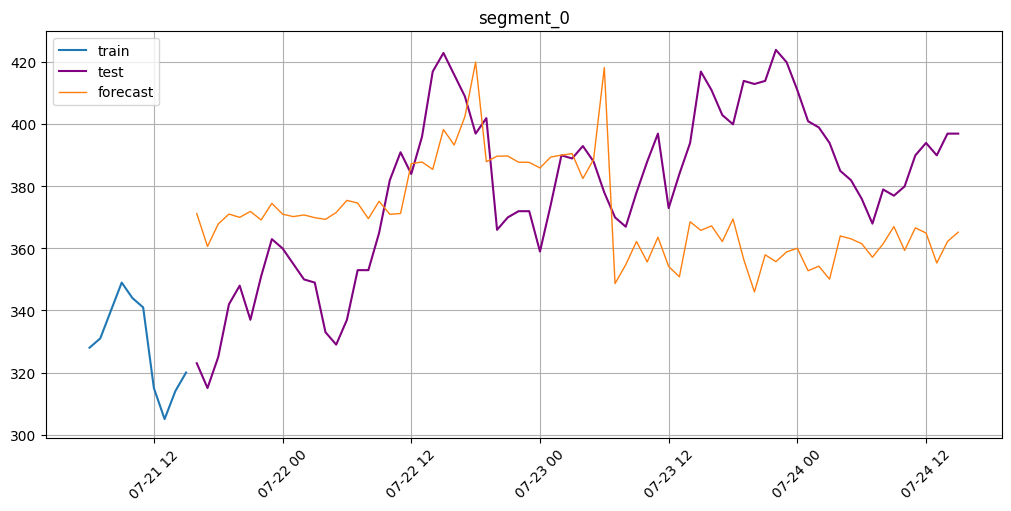

In [83]:
df_for_predict = get_etna_dataframe(sw_path=TRAIN_DATASET_PATH,
                                    using_measure_points=(VALIDATION_MEASURE_POINTS_END - HORIZON),
                                    target_list=target_list, 
                                    regressors_list=regressors_list,
                                    with_solar_cycle_order_day_feature=False)

df_real = get_etna_dataframe(sw_path=PATH_TO_DATASET,
                             using_measure_points=VALIDATION_MEASURE_POINTS_END,
                             target_list=target_list, 
                             regressors_list=regressors_list,
                             with_solar_cycle_order_day_feature=False)
df_real = TSDataset(df_real.df.tail(horizon), freq='h')

print("*** Статистика по датасету для прогнозирования ***\n")
print_TSDataset_statistic(df_for_predict)
print("*** Статистика по датасету c настоящими значениями прогноза ***\n")
print_TSDataset_statistic(df_for_predict)



pipeline = load(MODEL_SAVING_PATH)
print_pipeline_transform_and_regressors(pipeline, regressors_list)

print("Получаем предсказание...")

forecast = pipeline.forecast(df_for_predict)

plot_forecast(forecast_ts=forecast, test_ts=df_real, train_ts=df_for_predict, n_train_samples=10)
print(f"""Последние три значения датафрейма для предсказания:\n{df_for_predict.tail(3)}\n\n 
Предсказание(первые 3):\n {forecast.df["segment_0"]["target"].head(3)}\n\n 
Реальные данные (первые 3):\n {df_real.df["segment_0"]["target"].head(3)}\n\n""")
play_end_sound()

## Обучение с помощью Optuna

In [19]:
app = typer.Typer()


def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)


def init_logger(config: dict, project: str = "RNNModel", tags: Optional[list] = ["test", "sweeps"]):
    tslogger.loggers = []
    wblogger = WandbLogger(project=project, tags=tags, config=config)
    tslogger.add(wblogger)


def objective(trial: optuna.Trial, metric_name: str, ts: TSDataset, seed: int):
    """Optuna objective function."""

    # Set seed for reproducibility
    set_seed(seed)

    target_list = ['timestamp',
              'v_plasma']
    regressors_list = [
                   'timestamp',
                   # 'AU', # + на трендах вниз появились проблемы
                   'AE', # +
                   'Kp', # + 
                   # 'n_plasma', # +
                   'R', # +
                   # 'f107_adj', # +
                   'Dst', # +
                   'B_mag_avg', # +
    ]

    horizon = 72
    input_size = len(regressors_list)
    
    transforms=[
        MinMaxScalerTransform(in_column=None),
    ]
    
    pipeline = Pipeline(
        model = RNNModel(input_size=input_size,
                         decoder_length=horizon,
                         encoder_length=2*horizon,
                         num_layers=8,  # trial.suggest_int("num_layers", 3, 8),
                         hidden_size=8,  # trial.suggest_int("hidden_size", 16, 30),
                         lr=0.001,
                         test_batch_size=64,
                         train_batch_size=64,
                         trainer_params=dict(max_epochs=8,  # trial.suggest_int("(max_epochs", 5, 30),
                                             gpus=1,
                                            ),
                                ),
        transforms=transforms,
        horizon=horizon,
    )

    # Init WandB logger
    init_logger(pipeline.to_dict())

    # Start backtest
    metrics, _, _ = pipeline.backtest(ts=ts, metrics=[MAE(), SMAPE(), MSE()])
    return metrics[metric_name].mean()


@app.command()
def run_optuna(
    metric_name: str = "MAE",
    storage: str = "sqlite:///optuna.db",
    study_name: Optional[str] = None,
    n_trials: int = 1,
    file_path: Path = TRAIN_DATASET_PATH,
    direction: str = "minimize",
    freq: str = "D",
    seed: int = 11,
):
    """
    Run optuna optimization for DeepARModel.
    """
    # Load data
    target_list = ['timestamp',
              'v_plasma']

    
    regressors_list = [
                   'timestamp',
                   # 'AU', # + на трендах вниз появились проблемы
                   'AE', # +
                   'Kp', # + 
                   # 'n_plasma', # +
                   'R', # +
                   # 'f107_adj', # +
                   'Dst', # +
                   'B_mag_avg', # +
    ]
    ts = get_etna_dataframe(sw_path=TRAIN_DATASET_PATH,
                        using_measure_points=USING_MEASURE_POINTS,
                        target_list=target_list, 
                        regressors_list=regressors_list,
                        with_solar_cycle_order_day_feature=False)

    # Create Optuna study
    study = optuna.create_study(
        storage=storage,
        study_name=study_name,
        sampler=optuna.samplers.TPESampler(multivariate=True, group=True),
        load_if_exists=True,
        direction=direction,
    )

    # Run Optuna optimization
    study.optimize(
        partial(objective, metric_name=metric_name, ts=ts, seed=seed), n_trials=n_trials
    )

In [20]:
run_optuna()

[I 2024-05-21 17:14:56,431] A new study created in RDB with name: no-name-843db694-5b59-4ee1-adef-9febfe805569
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: andreiavdeencko (mstu). Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type    | Params
---------------------------------------
0 | loss       | MSELoss | 0     
1 | rnn        | LSTM    | 4.5 K 
2 | projection | Linear  | 9     
---------------------------------------
4.6 K     Trainable params
0         Non-trainable params
4.6 K     Total params
0.018     Total estimated model params size (MB)


Epoch 7: 100%|██████████| 265/265 [00:02<00:00, 110.07it/s, loss=0.000279, v_num=7fzd]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 265/265 [00:02<00:00, 109.52it/s, loss=0.000279, v_num=7fzd]


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train_loss_epoch,█▂▁▁▁▁▁▁
train_loss_step,▇█▇▇▆▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch,7
train_loss_epoch,0.00029
train_loss_step,0.00034
trainer/global_step,2119


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   38.2s


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type    | Params
---------------------------------------
0 | loss       | MSELoss | 0     
1 | rnn        | LSTM    | 4.5 K 
2 | projection | Linear  | 9     
---------------------------------------
4.6 K     Trainable params
0         Non-trainable params
4.6 K     Total params
0.018     Total estimated model params size (MB)


Epoch 7: 100%|██████████| 267/267 [00:02<00:00, 106.04it/s, loss=0.000272, v_num=c8bq]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 267/267 [00:02<00:00, 104.54it/s, loss=0.000272, v_num=c8bq]


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train_loss_epoch,█▂▁▁▁▁▁▁
train_loss_step,█▆▆▆▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch,7
train_loss_epoch,0.0003
train_loss_step,0.00024
trainer/global_step,2135


[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  1.2min


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type    | Params
---------------------------------------
0 | loss       | MSELoss | 0     
1 | rnn        | LSTM    | 4.5 K 
2 | projection | Linear  | 9     
---------------------------------------
4.6 K     Trainable params
0         Non-trainable params
4.6 K     Total params
0.018     Total estimated model params size (MB)


Epoch 7: 100%|██████████| 268/268 [00:02<00:00, 103.61it/s, loss=0.000284, v_num=kw2b]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 268/268 [00:02<00:00, 103.07it/s, loss=0.000284, v_num=kw2b]


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train_loss_epoch,█▂▁▁▁▁▁▁
train_loss_step,▇█▆█▆▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch,7
train_loss_epoch,0.00028
train_loss_step,0.00023
trainer/global_step,2143


[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  1.7min


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type    | Params
---------------------------------------
0 | loss       | MSELoss | 0     
1 | rnn        | LSTM    | 4.5 K 
2 | projection | Linear  | 9     
---------------------------------------
4.6 K     Trainable params
0         Non-trainable params
4.6 K     Total params
0.018     Total estimated model params size (MB)


Epoch 7: 100%|██████████| 269/269 [00:02<00:00, 103.21it/s, loss=0.000296, v_num=0ihr]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 269/269 [00:02<00:00, 102.60it/s, loss=0.000296, v_num=0ihr]


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train_loss_epoch,█▂▁▁▁▁▁▁
train_loss_step,███▇▆▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch,7
train_loss_epoch,0.0003
train_loss_step,0.00024
trainer/global_step,2151


[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:  2.3min


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type    | Params
---------------------------------------
0 | loss       | MSELoss | 0     
1 | rnn        | LSTM    | 4.5 K 
2 | projection | Linear  | 9     
---------------------------------------
4.6 K     Trainable params
0         Non-trainable params
4.6 K     Total params
0.018     Total estimated model params size (MB)


Epoch 7: 100%|██████████| 270/270 [00:03<00:00, 89.26it/s, loss=0.000324, v_num=8thg] 

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 270/270 [00:03<00:00, 88.93it/s, loss=0.000324, v_num=8thg]


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train_loss_epoch,█▂▁▁▁▁▁▁
train_loss_step,▇▇▅█▅▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch,7
train_loss_epoch,0.00029
train_loss_step,0.00033
trainer/global_step,2159


[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:  2.9min
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:  2.9min


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   12.6s


[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   25.2s


[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   37.7s


[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:   52.5s


[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:  1.1min


MAE_mean,▁
MAE_median,▁
MAE_percentile_25,▁
MAE_percentile_5,▁
MAE_percentile_75,▁
MAE_percentile_95,▁
MSE_mean,▁
MSE_median,▁
MSE_percentile_25,▁
MSE_percentile_5,▁
MSE_percentile_75,▁


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   25.4s


MAE_mean,▁
MAE_median,▁
MAE_percentile_25,▁
MAE_percentile_5,▁
MAE_percentile_75,▁
MAE_percentile_95,▁
MSE_mean,▁
MSE_median,▁
MSE_percentile_25,▁
MSE_percentile_5,▁
MSE_percentile_75,▁


[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:   53.0s


MAE_mean,▁
MAE_median,▁
MAE_percentile_25,▁
MAE_percentile_5,▁
MAE_percentile_75,▁
MAE_percentile_95,▁
MSE_mean,▁
MSE_median,▁
MSE_percentile_25,▁
MSE_percentile_5,▁
MSE_percentile_75,▁


[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  1.3min


MAE_mean,▁
MAE_median,▁
MAE_percentile_25,▁
MAE_percentile_5,▁
MAE_percentile_75,▁
MAE_percentile_95,▁
MSE_mean,▁
MSE_median,▁
MSE_percentile_25,▁
MSE_percentile_5,▁
MSE_percentile_75,▁


[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:  1.7min


MAE_mean,▁
MAE_median,▁
MAE_percentile_25,▁
MAE_percentile_5,▁
MAE_percentile_75,▁
MAE_percentile_95,▁
MSE_mean,▁
MSE_median,▁
MSE_percentile_25,▁
MSE_percentile_5,▁
MSE_percentile_75,▁


[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:  2.2min
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:  2.2min


MAE_mean,▁
MAE_median,▁
MAE_percentile_25,▁
MAE_percentile_5,▁
MAE_percentile_75,▁
MAE_percentile_95,▁
MSE_mean,▁
MSE_median,▁
MSE_percentile_25,▁
MSE_percentile_5,▁
MSE_percentile_75,▁


[I 2024-05-21 17:21:28,474] Trial 0 finished with value: 59.95702482279806 and parameters: {}. Best is trial 0 with value: 59.95702482279806.
